## Customer Segmentation Using KMeans Clustering Algorithm

### 1. Setup

In [3]:
!pip install pingouin

In [148]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, kruskal
import scikit_posthocs as sp
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
import pingouin as pg
from statsmodels.multivariate.manova import MANOVA
from sklearn. cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
import statsmodels.api as sm
from statsmodels.formula.api import ols

### 2. Data Collection 

In [6]:
CSV_PATH_CANDIDATES = [
    '/Users/rohilzalke/Desktop/DataSet/Online_Retail.xlsx'  
]

csv_path = None
for p in CSV_PATH_CANDIDATES:
    if os.path.exists(p):
        csv_path = p
        break

if csv_path is None:
    raise FileNotFoundError("Could not find 'Online_Retail.xlsx'. Place it in the notebook folder or update CSV_PATH_CANDIDATES.")

df = pd.read_excel(csv_path)
df.head()


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

### 3. Initial Data Checks

In [8]:
print("Shape of the dataframe: ", df.shape)
print("\nColumn Info:")
print(df.info())
print("\n Missing values per columns:")
print(df.isnull().sum())
print("Basic Statistics: ")
print(df.describe)
print("\nDistribution of Country")
print(df['Country'].value_counts(normalize=True))
print("\nAre there any dublicates in the dataframe:", df.duplicated().any())
df = df.drop_duplicates()
print("\nDublicates are removed by df = df.drop_duplicates()")

Shape of the dataframe:  (541909, 8)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None

 Missing values per columns:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
Basic Statistics: 
<bound method 

### 4. Data Cleaning

In [10]:
#Removing the column customer from the dataframe
#df = df.drop(columns = ['CustomerID'])

#If this code starts with letter 'c', it indicates a cancellation. Removing cancellation rows
df = df[~df["InvoiceNo"].astype(str).str.startswith('C')]

#Removing zeros or negative values
df = df[(df["Quantity"] > 0) & (df["UnitPrice"] > 0)]

In [11]:
print("Shape of the dataframe: ", df.shape)

Shape of the dataframe:  (524878, 8)


### 5. Feature Engineering

In [13]:
ref_date = df['InvoiceDate'].max() + dt.timedelta(days = 1)

In [14]:
rfm = df.groupby('CustomerID').agg({
    "InvoiceDate": lambda x: (ref_date-x.max()).days,
    "InvoiceNo": 'nunique',
    "Quantity": 'sum',
    "Quantity": 'mean' 
})

In [15]:
# Rename columns
rfm.rename(columns={
    "InvoiceDate": "Recency",
    "InvoiceNo": "Frequency",
    "Quantity": "TotalQuantity",
    "UnitPrice": "AvgUnitPrice"
}, inplace=True)


In [16]:
df['TotalPrice'] = df['Quantity']*df['UnitPrice']
monetary = df.groupby("CustomerID")['TotalPrice'].sum()
rfm["Monetary"] = monetary

In [17]:
rfm.head()

Recency  Frequency  TotalQuantity  Monetary
CustomerID                                             
12346.0         326          1   74215.000000  77183.60
12347.0           2          7      13.505495   4310.00
12348.0          75          4      75.516129   1797.24
12349.0          19          1       8.643836   1757.55
12350.0         310          1      11.588235    334.40

### 6. Exploratory Data Analysis (EDA)

##### i. Descriptive Statistics

In [20]:
print(rfm[['Recency', 'Frequency', 'TotalQuantity', 'Monetary']].describe())

           Recency    Frequency  TotalQuantity       Monetary
count  4338.000000  4338.000000    4338.000000    4338.000000
mean     92.536422     4.272015      45.080599    2048.688081
std     100.014169     7.697998    1203.437983    8985.230220
min       1.000000     1.000000       1.000000       3.750000
25%      18.000000     1.000000       6.042120     306.482500
50%      51.000000     2.000000      10.000000     668.570000
75%     142.000000     5.000000      14.666667    1660.597500
max     374.000000   209.000000   74215.000000  280206.020000


In [21]:
# Skewness & Kurtosis
for col in ['Recency', 'Frequency', 'Monetary']: 
    print(f"{col}: Skewness = {rfm[col].skew():.2f}, kurtosis = {rfm[col].kurt():.2f}")

Recency: Skewness = 1.25, kurtosis = 0.43
Frequency: Skewness = 12.07, kurtosis = 249.06
Monetary: Skewness = 19.34, kurtosis = 478.68


##### Kurtosis measures the "tailedness" or outlier intensity of a distribution compared to a normal distribution.
##### Using excess kurtosis (common in Python scipy.stats.kurtosis with fisher=True):
##### 0 → Normal distribution (mesokurtic).
##### > 0 → Heavy tails, sharp peak (leptokurtic).
##### < 0 → Light tails, flat peak (platykurtic).

##### 1. Recency
##### Recency = number of days since the customer’s last purchase.
##### Lower Recency = more recent activity (good).
##### Higher Recency = customer hasn’t purchased in a long time (bad).
##### If Recency Skewness > 1 (positive skew), it means Distribution is right-skewed.
##### That means: Most customers have low Recency values (recently active). A smaller number of customers have very high Recency (haven’t purchased in a long time).

##### If Recency Kurtosis < 1: The distribution is flatter and more spread out compared to normal. Tails are ##### lighter → fewer extreme outliers (very old customers are less influential). Data is more evenly spread ##### instead of being dominated by a sharp peak.

##### 2. Frequency
##### Frequency is how many times each customers made a purchase
##### Skewness = 12.07:  Most customers purchase very few times (like once or twice). A tiny fraction of customers purchase many, many times. That tiny group creates a long right tail in the data.
##### Kurtosis = 249.06: A normal distribution has kurtosis ≈ 0. But 249 is enormously high, meaning: The distribution has a very sharp peak at low frequency (lots of 1-time buyers). The tails are extremely heavy → just a few super-buyers make unusually high numbers of purchases.

##### 3. Monetary
##### Monetary is how much money each customer has spent in total.
##### Skewness = 19.34: That’s extremely positive skew (even stronger than your Frequency case). Most customers spend very little. A few customers spend huge amounts → pulling the tail far to the right.
##### Kurtosis = 478.68: 478 is gigantic → indicates ultra-heavy tails and extreme outliers. The distribution has a sharp spike near low-spending customers. And a handful of super-spenders (whales) who dominate the tail. Those outliers are so extreme that they overwhelm the distribution.


##### 3.2 Visualizing Distributions

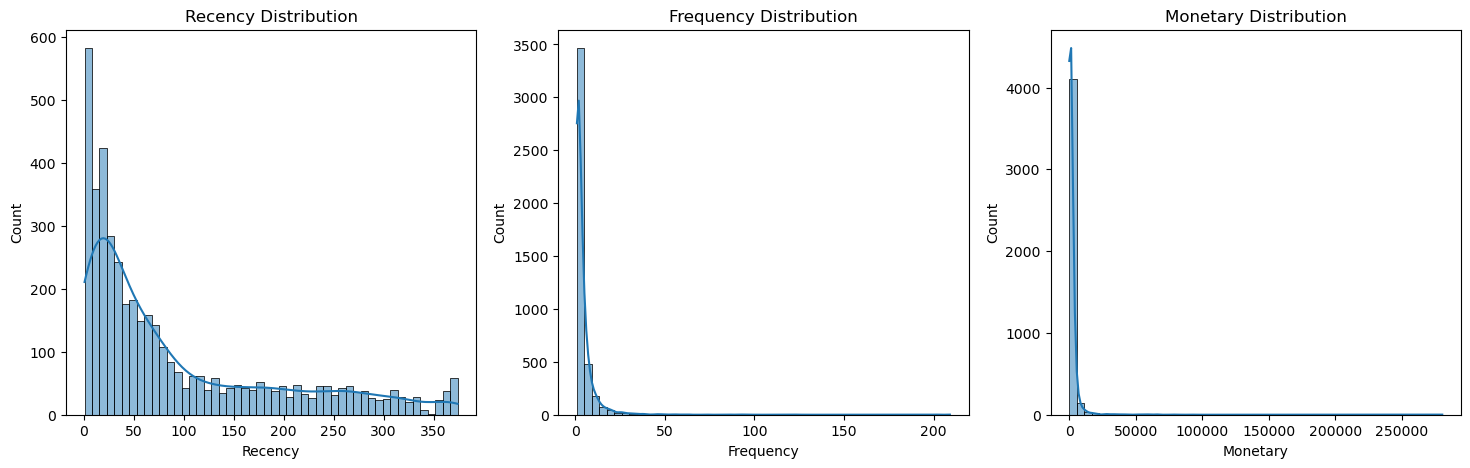

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm["Recency"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Recency Distribution")

sns.histplot(rfm["Frequency"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Frequency Distribution")

sns.histplot(rfm["Monetary"], bins=50, kde=True, ax=axes[2])
axes[2].set_title("Monetary Distribution")

plt.show()

##### 3.3 Outlier Detection using Boxplots

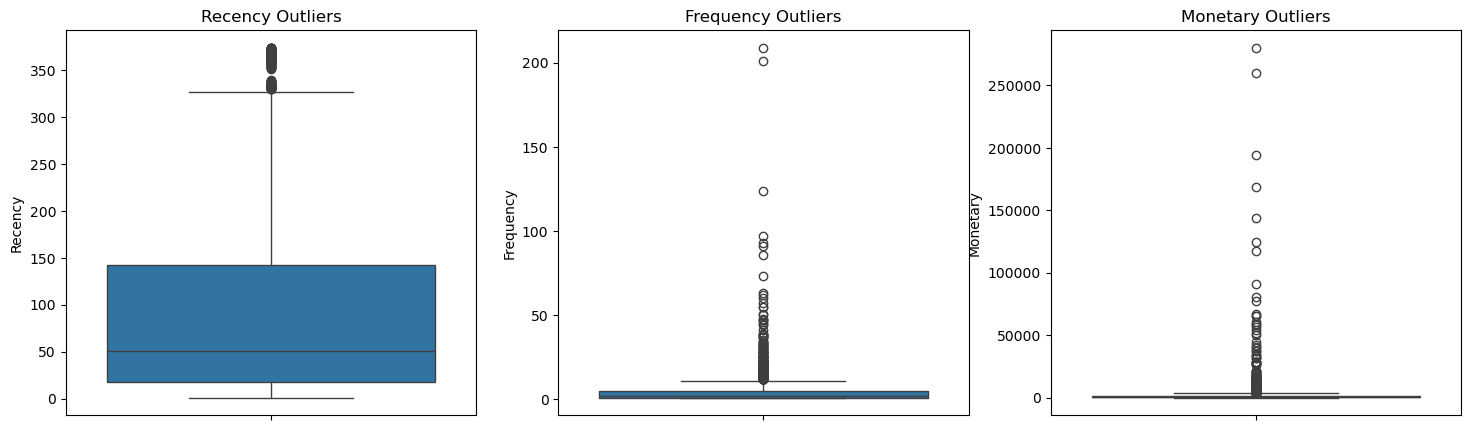

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(y=rfm["Recency"], ax=axes[0])
axes[0].set_title("Recency Outliers")

sns.boxplot(y=rfm["Frequency"], ax=axes[1])
axes[1].set_title("Frequency Outliers")

sns.boxplot(y=rfm["Monetary"], ax=axes[2])
axes[2].set_title("Monetary Outliers")

plt.show()

### 7. Statistical Analysis

##### 7.1 Hypothesis Testing

In [29]:
cols = ['Quantity', 'UnitPrice', 'TotalPrice']
for m in cols:
    stats, p = shapiro(df[m].sample(5000, random_state=42))
    print(f"{m}: W={stats:.2f}, p={p:.3e}")
    if p> 0.05: 
        print(f"{m} is normally distributed")
    else:
        print(f"{m} is not normally distributed")

Quantity: W=0.15, p=3.651e-92
Quantity is not normally distributed
UnitPrice: W=0.01, p=1.465e-95
UnitPrice is not normally distributed
TotalPrice: W=0.07, p=3.106e-94
TotalPrice is not normally distributed


In [30]:
top_countries = df['Country'].value_counts().index[:4]
data = [df[df['Country']==c].groupby('CustomerID')['TotalPrice'].sum() 
        for c in top_countries]
df['TotalPrice'].isna().sum()  # should be 0
# Remove empty Series (if any)
data = [d for d in data if not d.empty]
stats, p = kruskal(*data)
print("H-statistic:", stats)
print("p-value:", p)

if p < 0.05:
    print("At least one group is significantly different")
else:
    print("No significant difference between groups")

H-statistic: 32.63312039751059
p-value: 3.848768303906287e-07
At least one group is significantly different


##### Kruskal–Wallis tells you whether at least one group is different from the others. But it does not tell you which specific groups differ. That’s where post hoc tests like Dunn’s test come in.


In [32]:
posthoc = sp.posthoc_dunn(data, p_adjust='bonferroni')
posthoc.index = top_countries[:len(data)]
posthoc.columns = top_countries[:len(data)]

print("\nPost-hoc Dunn’s test (adjusted p-values):")
print(posthoc)


Post-hoc Dunn’s test (adjusted p-values):
Country         United Kingdom   Germany    France      EIRE
Country                                                     
United Kingdom        1.000000  0.000089  0.075692  0.024073
Germany               0.000089  1.000000  1.000000  0.234951
France                0.075692  1.000000  1.000000  0.106879
EIRE                  0.024073  0.234951  0.106879  1.000000


In [33]:
df['TotalPrice'].isna().sum()  # should be 0

0

In [34]:
from scipy.stats import f_oneway

# Take top 3 countries by customer count
top_countries = df["Country"].value_counts().index[:3]
anova_data = [df[df["Country"] == c].groupby("CustomerID")["TotalPrice"].sum() 
              for c in top_countries]

# ANOVA test
f_stat, p_val = f_oneway(*anova_data)
print("ANOVA F-stat:", f_stat, "p-value:", p_val)

ANOVA F-stat: 0.5013744991849851 p-value: 0.6057347058136882


In [35]:
for j in rfm.columns:
    W_stats, p = shapiro(rfm[j].sample(5000, replace=True))
    print(f"Shapiro-Wilk Test for {j}: W-statistic = {W_stats:.2f} & P_value = {p:.3f}")

#print(f"{m}: W={stats:.2f}, p={p:.3e}")

Shapiro-Wilk Test for Recency: W-statistic = 0.81 & P_value = 0.000
Shapiro-Wilk Test for Frequency: W-statistic = 0.33 & P_value = 0.000
Shapiro-Wilk Test for TotalQuantity: W-statistic = 0.02 & P_value = 0.000
Shapiro-Wilk Test for Monetary: W-statistic = 0.22 & P_value = 0.000


In [36]:
stats, p_value = shapiro(rfm["Monetary"].sample(5000, replace=True))
print("Shapiro-Wilk Test: Stat:%.3f & p=%.3f" % (stats, p_value))

Shapiro-Wilk Test: Stat:0.127 & p=0.000


##### W-statistic: This statistics Ranges from 0 to 1. Values close to 1 → data looks normal. Values much lower → strong evidence of non-normality.

##### Recency: 0.81 (W-statistic) - Not normal (moderately skewed)
##### Frequency: 0.35 (W-statistic) - Strongly not normal (heavily skewed)
##### TotalQuantity: 0.02 (W-statistic) - Extremely non-normal (very heavy skew/outliers)
##### Monetary: 0.13 (W-statistic) - Extremely non-normal (very heavy skew/outliers)


#### 7.2 Correlation & Association

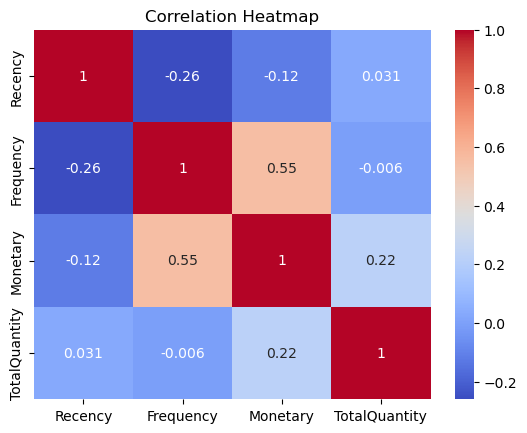

In [39]:
# Pearson → linear correlation.
corr = rfm[["Recency", "Frequency", "Monetary", "TotalQuantity"]].corr(method="pearson")
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

In [40]:
# Spearman → monotonic correlation (use if skewed).
corr_spearman = rfm[["Recency", "Frequency", "Monetary", "TotalQuantity"]].corr(method="spearman")
print(corr_spearman)

                Recency  Frequency  Monetary  TotalQuantity
Recency        1.000000  -0.562392 -0.480617      -0.040798
Frequency     -0.562392   1.000000  0.807185       0.089112
Monetary      -0.480617   0.807185  1.000000       0.238936
TotalQuantity -0.040798   0.089112  0.238936       1.000000


#### 7.3 Multivariate Statistics

##### 1. Principal Component Analysis

In [43]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.55473084 0.30252713]


##### PC1 (first component) = 0.5547 → ~55.5% of variance captured & PC2 (second component) = 0.3025 → ~30.3% of variance captured. Together, these two capture:
##### 55.5% + 30.3% = 85.8%
##### So your first 2 components explain about 85.8% of the total information in the data.

##### 2. Hotelling’s T² Test

In [46]:
rfm_new = rfm.copy()
rfm_new = rfm.merge(df[['CustomerID', 'Country']].drop_duplicates(), on = 'CustomerID', how='left')

rfm_log_scale = rfm_new.copy()
rfm_log_scale['Recency'] = np.log1p(rfm_log_scale['Recency'])
rfm_log_scale['Frequency'] = np.log1p(rfm_log_scale['Frequency'])
rfm_log_scale['Monetary'] = np.log1p(rfm_log_scale['Monetary'])

scaler_log_scale = StandardScaler()
rfm_log_scale['Recency'] = scaler_log_scale.fit_transform(rfm_log_scale[['Recency']])
rfm_log_scale['Frequency'] = scaler_log_scale.fit_transform(rfm_log_scale[['Frequency']])
rfm_log_scale['Monetary'] = scaler_log_scale.fit_transform(rfm_log_scale[['Monetary']])

##### RFM variables (Recency, Frequency, Monetary) were highly skewed. To address this, I applied a log transformation.
##### The log transformation compresses large values more than small values, which reduces skewness and makes the distribution more symmetric. It also reduces the impact of extreme outliers and heavy tails (very high kurtosis). This makes the data closer to a normal distribution, which is essential for Hotelling’s T² and MANOVA to give reliable results.
##### After the log transformation, the variables were still on different scales. Since Hotelling’s T² and MANOVA are based on distances and variance–covariance matrices, variables with larger ranges could dominate the results.
##### Therefore, I applied standardization (zero mean, unit variance) on the log-transformed data, so that each variable contributes equally to the multivariate analysis.

In [48]:
c1 = rfm_log_scale[rfm_log_scale['Country']=='United Kingdom'].groupby('CustomerID')[['Recency', 'Frequency', 'Monetary']].mean()
c2 = rfm_log_scale[rfm_log_scale['Country']=='Germany'].groupby('CustomerID')[['Recency', 'Frequency', 'Monetary']].mean()

for k in ['Recency', 'Frequency', 'Monetary']:
    stats, p = ttest_ind(c1[k], c2[k], equal_var=False)
    print(f"{k}: t= {stats:.2f}, p= {p:3f}")

Recency: t= 1.35, p= 0.178916
Frequency: t= -1.50, p= 0.136718
Monetary: t= -4.50, p= 0.000019


In [49]:
c1 = rfm_log_scale[rfm_log_scale['Country']=='United Kingdom'].groupby('CustomerID')[['Recency', 'Frequency', 'Monetary']].mean()
c2 = rfm_log_scale[rfm_log_scale['Country']=='France'].groupby('CustomerID')[['Recency', 'Frequency', 'Monetary']].mean()

for k in ['Recency', 'Frequency', 'Monetary']:
    stats, p = ttest_ind(c1[k], c2[k], equal_var=False)
    print(f"{k}: t= {stats:.2f}, p= {p:3f}")

Recency: t= 1.14, p= 0.256743
Frequency: t= -1.04, p= 0.299545
Monetary: t= -2.57, p= 0.011888


In [50]:
c1 = rfm_log_scale[rfm_log_scale['Country']=='Germany'].groupby('CustomerID')[['Recency', 'Frequency', 'Monetary']].mean()
c2 = rfm_log_scale[rfm_log_scale['Country']=='France'].groupby('CustomerID')[['Recency', 'Frequency', 'Monetary']].mean()

for k in ['Recency', 'Frequency', 'Monetary']:
    stats, p = ttest_ind(c1[k], c2[k], equal_var=False)
    print(f"{k}: t= {stats:.2f}, p= {p:3f}")

pg.multivariate_ttest(c1, c2)

Recency: t= -0.07, p= 0.946498
Frequency: t= 0.33, p= 0.744664
Monetary: t= 1.03, p= 0.302234


T2         F  df1  df2      pval
hotelling  2.003214  0.660277    3  177  0.577533

##### The t is the test statistic that measures how large the mean difference between your two groups is, in units of standard error.

##### If p < 0.05, the the two groups are highly significant for the specifica feature and they differ significantly else No strong evidence that the two groups differ in the specific feature. 

##### We have got the t test statisitc very small and hence p-valuenis also greater than 0.05, which means that the groups have no strong evidence the the groups differ. 

##### 3. MANOVA (Multivariate ANOVA)

In [53]:
moav = MANOVA.from_formula("Recency + Frequency + Monetary ~ Country", data = rfm_log_scale)
print(moav.mv_test())

                    Multivariate linear model
                                                                 
-----------------------------------------------------------------
          Intercept        Value  Num DF   Den DF  F Value Pr > F
-----------------------------------------------------------------
             Wilks' lambda 0.9971 3.0000 4307.0000  4.1679 0.0059
            Pillai's trace 0.0029 3.0000 4307.0000  4.1679 0.0059
    Hotelling-Lawley trace 0.0029 3.0000 4307.0000  4.1679 0.0059
       Roy's greatest root 0.0029 3.0000 4307.0000  4.1679 0.0059
-----------------------------------------------------------------
                                                                 
-----------------------------------------------------------------
        Country         Value   Num DF    Den DF   F Value Pr > F
-----------------------------------------------------------------
          Wilks' lambda 0.9136 108.0000 12899.8015  3.6607 0.0000
         Pillai's trace 0.0883

##### Wilks’ Lambda (0.9136): closer to 1 = groups are somewhat similar, but since p < 0.001, there is still a statistically significant difference.
##### Pillai’s Trace, Hotelling-Lawley, Roy’s root all confirm significance (p < 0.001).
##### Conclusion is that at least one of Recency, Frequency, or Monetary differs significantly across Countries.
##### Customers from different countries show statistically different multivariate shopping behavior (in terms of R, F, M).
##### This strengthens the business justification for segmentation: you can’t treat all countries/customers the same.

### 8. K-means Clustering

#### 8.1 Optional K Selection

In [57]:
df_new = rfm_log_scale.copy()
df_new = rfm_log_scale.drop(['CustomerID', 'Country', 'TotalQuantity'], axis=1)

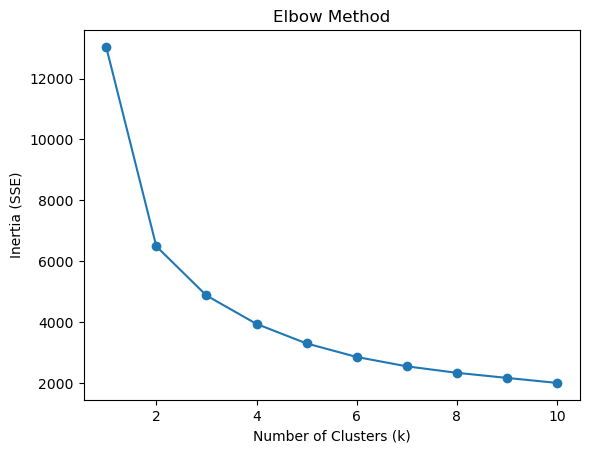

In [58]:
inertia = []
K = range(1, 11)
for k in K:
    kmean = KMeans(n_clusters = k, random_state = 42, n_init=10)
    kmean.fit(df_new)
    inertia.append(kmean.inertia_)

plt.plot(K, inertia, 'o-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method")
plt.show()

#### 8.2 Silhouette Score
##### Measures how well-separated clusters are (ranges from -1 to 1).

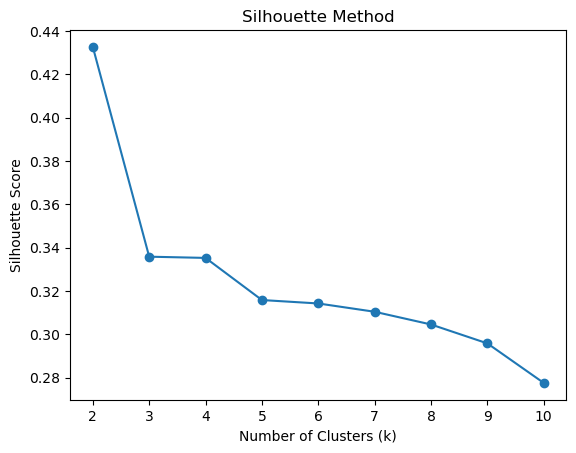

In [60]:
silhouette = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_new)
    silhouette.append(silhouette_score(df_new, labels))

plt.plot(range(2, 11), silhouette, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")
plt.show()

#### 8.3 Final K-means Model

In [62]:
rfm_clusters = df_new.copy()
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm_clusters['Clusters'] = kmeans.fit_predict(df_new)

#### 8.4 Cluster Profilling

In [64]:
Cluster_profile = rfm_clusters.groupby('Clusters')[['Recency', 'Frequency', 'Monetary']].mean()

In [65]:
print(Cluster_profile)

           Recency  Frequency  Monetary
Clusters                               
0        -0.785536  -0.419170 -0.443553
1         0.108293   0.339766  0.530592
2        -1.259271   1.650966  1.392729
3         0.917725  -0.772151 -0.783013


##### Cluster 0: “Average Customers”
###### Recency = -0.79 → purchased more recently than average.
###### Frequency & Monetary both slightly below average.
###### Interpretation: These are steady customers, not high spenders, but still active.

##### Cluster 1: “Above-Average Spenders”
###### Recency = +0.11 → about average recency.
###### Frequency = +0.34 → buy more frequently than average.
###### Monetary = +0.53 → spend more than average.
###### Interpretation: These are good customers — they spend more than most and return regularly, but not the very best segment.

##### Cluster 2: “Best / Loyal Customers”
###### Recency = -1.26 → bought very recently (most active).
###### Frequency = +1.65 → extremely frequent buyers.
###### Monetary = +1.39 → spend a lot.
###### Interpretation: These are the VIP customers — loyal, frequent, and high spenders. These are the most valuable segment.

##### Cluster 3: “At Risk / Lost Customers”
###### Recency = +0.92 → haven’t bought for a long time.
###### Frequency = -0.77 → purchase rarely.
###### Monetary = -0.78 → spend little.
###### Interpretation: These are churn-risk or lost customers — infrequent, low-value, and haven’t purchased in a while.

### 9. Visualization

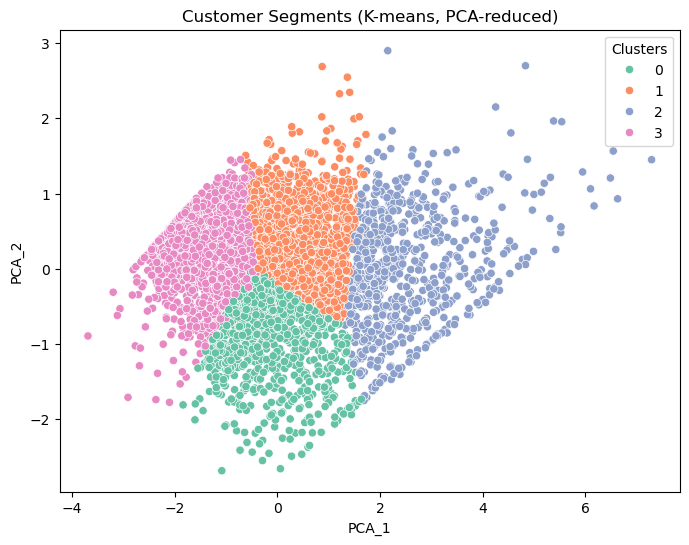

In [68]:
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(df_new)

rfm_clusters['PCA_1'] = rfm_pca[:,0]
rfm_clusters['PCA_2'] = rfm_pca[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm_clusters, x="PCA_1", y="PCA_2", hue="Clusters", palette="Set2")
plt.title("Customer Segments (K-means, PCA-reduced)")
plt.show()

### 10. 3-D Visualization

In [70]:
fig = px.scatter_3d(rfm_clusters, x="Recency", y="Frequency", z="Monetary", color="Clusters", opacity=0.7)
fig.show()

### 11. Comparing Clusters With And Without PCA

##### 11.1 PCA transformation

In [73]:
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(df_new)

rfm_clusters_pca = pd.DataFrame(rfm_pca, columns=["PCA1","PCA2"], index=df_new.index)
rfm_clusters_pca["Cluster"] = kmeans.labels_  # use same cluster labels as before

In [74]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total variance explained:", sum(pca.explained_variance_ratio_))

Explained variance ratio: [0.75073905 0.18794487]
Total variance explained: 0.9386839250201995


##### 11.2 Clustering with PCA

In [76]:
kmeans_pca = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm_clusters_pca["Cluster_PCA"] = kmeans_pca.fit_predict(rfm_pca)

##### 11.3 Comparing Cluster Qulaity by Checking Silhouette Score in both cases

In [78]:
sil_original = silhouette_score(df_new, kmeans.labels_)
sil_pca = silhouette_score(rfm_pca, kmeans_pca.labels_)

print("Silhouette (Original RFM):", sil_original)
print("Silhouette (PCA-reduced):", sil_pca)

Silhouette (Original RFM): 0.33524586260454053
Silhouette (PCA-reduced): 0.38213275162587584


##### 11.3 Visualization

###### Without PCA (use PCA only for visualization)

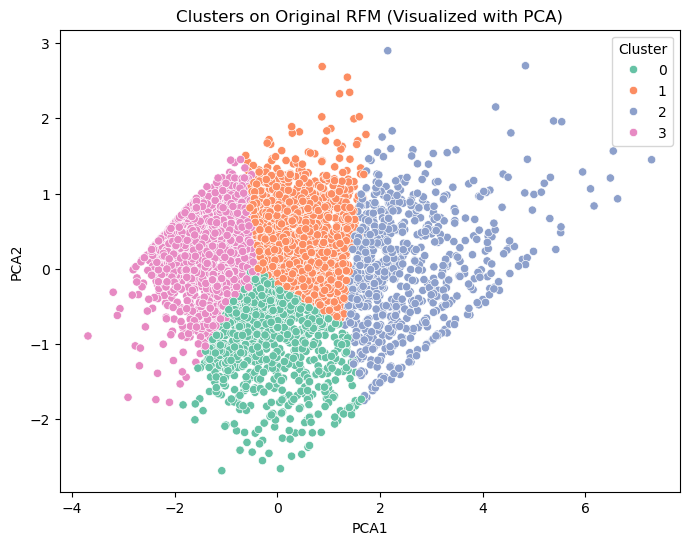

In [81]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm_clusters_pca, x="PCA1", y="PCA2", hue="Cluster", palette="Set2")
plt.title("Clusters on Original RFM (Visualized with PCA)")
plt.show()

###### With PCA-based clustering

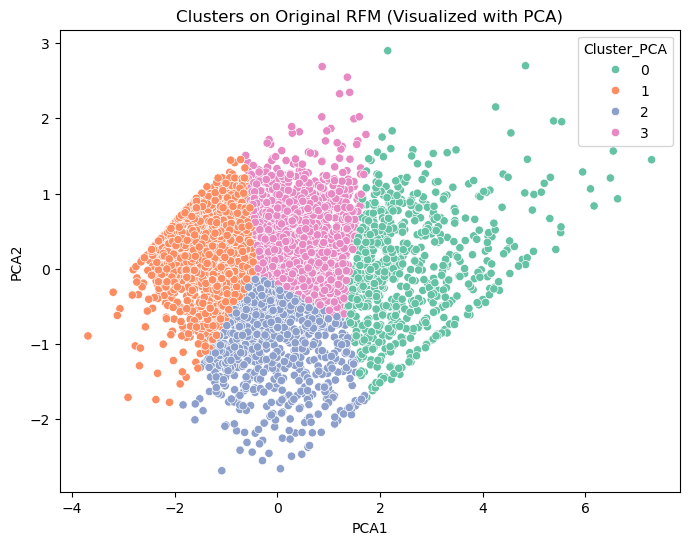

In [83]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=rfm_clusters_pca, x="PCA1", y="PCA2", hue="Cluster_PCA", palette="Set2")
plt.title("Clusters on Original RFM (Visualized with PCA)")
plt.show()

### 12. Statistical Validation of Clusters

#### 12.1 Hotelling’s T² Test (pairwise cluster comparison)

In [86]:
df_new['Clusters'] = kmeans.labels_
c0 = df_new[df_new['Clusters']==0][['Recency', 'Frequency', 'Monetary']]
c1 = df_new[df_new['Clusters']==1][['Recency', 'Frequency', 'Monetary']]
c2 = df_new[df_new['Clusters']==2][['Recency', 'Frequency', 'Monetary']]
c3 = df_new[df_new['Clusters']==3][['Recency', 'Frequency', 'Monetary']]

In [87]:
pg.multivariate_ttest(c0, c1)

T2            F  df1   df2  pval
hotelling  4452.438603  1482.688297    3  2034   0.0

In [88]:
pg.multivariate_ttest(c0, c2)

T2            F  df1   df2  pval
hotelling  4527.62003  1507.297497    3  1579   0.0

In [89]:
pg.multivariate_ttest(c0, c3)

T2            F  df1   df2  pval
hotelling  6192.437103  2062.459996    3  2447   0.0

In [90]:
pg.multivariate_ttest(c1, c2)

T2            F  df1   df2  pval
hotelling  3960.063405  1318.626501    3  1891   0.0

In [91]:
pg.multivariate_ttest(c1, c3)

T2            F  df1   df2  pval
hotelling  8490.73176  2828.193761    3  2759   0.0

In [92]:
pg.multivariate_ttest(c2, c3)

T2            F  df1   df2  pval
hotelling  18461.634278  6148.540818    3  2304   0.0

#### 12.2 MANOVA (all clusters at once)

In [93]:
manova_df = df_new.copy()

# Run MANOVA
maov = MANOVA.from_formula("Recency + Frequency + Monetary ~ Clusters", data=df_new)
print(maov.mv_test())

                   Multivariate linear model
                                                               
---------------------------------------------------------------
       Intercept        Value  Num DF   Den DF  F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda 0.7580 3.0000 4342.0000 462.0579 0.0000
         Pillai's trace 0.2420 3.0000 4342.0000 462.0579 0.0000
 Hotelling-Lawley trace 0.3192 3.0000 4342.0000 462.0579 0.0000
    Roy's greatest root 0.3192 3.0000 4342.0000 462.0579 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
        Clusters        Value  Num DF   Den DF  F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda 0.6814 3.0000 4342.0000 676.6376 0.0000
         Pillai's trace 0.3186 3.0000 4342.0000 676.6376 0.

#### The MANOVA table tells us that the clusters differ on the combination of Recency, Frequency, and Monetary (RFM) taken together. But MANOVA doesn’t tell us which of Recency, Frequency, or Monetary is driving the difference. That’s why we will follow up with univariate ANOVAs

#### 12.3 ANOVA for each dependent variable

In [152]:
# Recency ~ Cluster
model_recency = ols("Recency ~ C(Clusters)", data=df_new).fit()
anova_recency = sm.stats.anova_lm(model_recency, typ=2)
print("ANOVA: Recency by Cluster\n", anova_recency)

# Frequency ~ Cluster
model_frequency = ols("Frequency ~ C(Clusters)", data=df_new).fit()
anova_frequency = sm.stats.anova_lm(model_frequency, typ=2)
print("\nANOVA: Frequency by Cluster\n", anova_frequency)

# Monetary ~ Cluster
model_monetary = ols("Monetary ~ C(Clusters)", data=df_new).fit()
anova_monetary = sm.stats.anova_lm(model_monetary, typ=2)
print("\nANOVA: Monetary by Cluster\n", anova_monetary)

ANOVA: Recency by Cluster
                   sum_sq      df            F  PR(>F)
C(Clusters)  3025.502263     3.0  3316.105855     0.0
Residual     1320.497737  4342.0          NaN     NaN

ANOVA: Frequency by Cluster
                   sum_sq      df            F  PR(>F)
C(Clusters)  3196.562834     3.0  4025.006394     0.0
Residual     1149.437166  4342.0          NaN     NaN

ANOVA: Monetary by Cluster
                   sum_sq      df            F  PR(>F)
C(Clusters)  2870.778289     3.0  2816.507567     0.0
Residual     1475.221711  4342.0          NaN     NaN


##### In Recency, F = 3316.1, p < 0.001. This is a very strong evidence that clusters differ in Recency. At least one cluster has customers who buy much more recently than others.

##### In Frequency, F = 4025.0, p < 0.001. This is even stronger evidence that clusters differ in Frequency. Some groups shop far more often than others.

##### In Monetary, F = 2816.5, p < 0.001. This is a strong evidence that clusters differ in Monetary value. Some clusters represent high-spending customers, others low spenders.

##### Since all p-values = 0.0 (actually < 0.0001) → all three RFM variables contribute significantly to cluster separation.


#### 13. Conclusion 

##### We applied K-means clustering on RFM features of Online Retail customers and identified 4 distinct segments:
##### a) VIP Customers: Recent, frequent, and high spenders → reward with loyalty programs.
##### b) Above-Average Spenders: Spend and shop more than average → target with upselling.
##### c) Average Customers: Moderate buyers → nudge with personalized offers.
##### d) Lost Customers: Inactive and low spenders → re-engagement campaigns.
##### MANOVA and ANOVA tests confirmed that Recency, Frequency, and Monetary all differ significantly across clusters (p < 0.001), proving the clusters are statistically meaningful.